In [138]:
import pandas as pd
import numpy as np
import io
import sagemaker.amazon.common as smac
from pandas import DataFrame
import boto3
from sagemaker import get_execution_role
import sagemaker
from sagemaker import KMeans
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
role = get_execution_role()
bucket='mymoviebucket'
sub_folder = 'ml-latest-small'

In [140]:
data_key = 'movies.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
movies = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')
moviesSave = movies
data_key = 'ratings.csv'
data_location = 's3://{}/{}/{}'.format(bucket, sub_folder, data_key)
ratings = pd.read_csv(data_location, low_memory=False, delimiter=',', encoding='utf-8')

In [141]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [142]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [143]:
ratings = ratings.drop(['timestamp'], axis=1)
ratings['UserRatingCount'] = ratings.groupby('userId')['userId'].transform('count')

In [144]:
ratings

,userId,movieId,rating,UserRatingCount
0,1,1,4.0,232
1,1,3,4.0,232
2,1,6,4.0,232
3,1,47,5.0,232
4,1,50,5.0,232
...,...,...,...,...
100831,610,166534,4.0,1302
100832,610,168248,5.0,1302
100833,610,168250,5.0,1302
100834,610,168252,5.0,1302


In [145]:
movies['genres'] = movies.genres.str.split('|')

In [146]:
dataframe = movies
x = []
for i, r in movies.iterrows():
    x.append(i)
    for genero in r['genres']:
        dataframe.at[i, genero] = 1

In [147]:
movies = movies.fillna(0)
movies = movies.drop(['genres','title'], axis=1)
movies

,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9738,193583,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9739,193585,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9740,193587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
dataframe = pd.merge(ratings, movies, on='movieId')
dataframe = dataframe.sort_values('userId')
dataframe

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


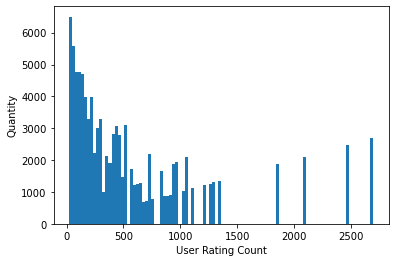

In [149]:
x = dataframe['UserRatingCount']
n_bins = 100
plt.hist(x, bins=n_bins)
plt.xlabel('User Rating Count')
plt.ylabel('Quantity')
plt.show()

In [150]:
dataframe[dataframe['UserRatingCount'] >= 1500]['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
Name: userId, dtype: int64

In [151]:
dataframe.drop(dataframe[dataframe['UserRatingCount'] >= 1500].index, inplace=True)

In [152]:
dataframe.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']] = dataframe.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']].multiply(dataframe.loc[:, 'rating'], axis='index')
dataframe

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,4.0,4.0,4.0,4.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,4.0,0.0,0.0,4.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.0,0.0,0.0,3.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.0,4.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
dataframe.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']] = dataframe.loc[:,['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']].divide(dataframe.loc[:, 'UserRatingCount'], axis='index')
dataframe

,userId,movieId,rating,UserRatingCount,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,4.0,232,0.017241,0.017241,0.017241,0.017241,0.017241,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12117,1,2389,2.0,232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.008621,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12126,1,2395,5.0,232,0.000000,0.000000,0.000000,0.021552,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12182,1,2406,4.0,232,0.017241,0.000000,0.000000,0.017241,0.000000,0.017241,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,1,70,3.0,232,0.000000,0.000000,0.000000,0.012931,0.000000,0.000000,...,0.012931,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84152,610,51709,5.0,1302,0.000000,0.000000,0.000000,0.003840,0.000000,0.000000,...,0.003840,0.0,0.00384,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26937,610,589,5.0,1302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00384,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69808,610,66097,4.0,1302,0.000000,0.003072,0.000000,0.000000,0.003072,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69820,610,71464,4.0,1302,0.000000,0.000000,0.000000,0.003072,0.000000,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
dataframe = dataframe.groupby(['userId'], as_index=False)['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)'].sum()
dataframe

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,userId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1.607759,0.586207,0.823276,1.530172,0.870690,0.482759,1.327586,1.676724,0.844828,...,0.254310,0.323276,0.728448,0.426724,0.443966,0.000000,0.000000,0.129310,0.021552,0.0
1,2,0.431034,0.000000,0.000000,0.965517,0.000000,0.155172,2.275862,1.500000,1.310345,...,0.103448,0.275862,0.534483,0.155172,0.000000,0.448276,0.517241,0.120690,0.000000,0.0
2,3,0.769231,0.051282,0.064103,0.230769,0.346154,0.064103,0.307692,1.282051,0.025641,...,0.961538,0.128205,1.615385,0.064103,0.012821,0.000000,0.000000,0.000000,0.000000,0.0
3,4,0.490741,0.111111,0.175926,1.689815,0.324074,0.907407,1.935185,0.384259,0.476852,...,0.078704,0.370370,0.157407,0.115741,0.296296,0.037037,0.013889,0.175926,0.074074,0.0
4,5,0.590909,0.590909,0.840909,1.181818,0.659091,0.772727,2.159091,0.636364,1.045455,...,0.068182,0.090909,0.113636,0.227273,0.500000,0.000000,0.250000,0.136364,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,606,0.461883,0.139910,0.151570,1.346188,0.313004,1.191031,2.371300,0.430493,0.435874,...,0.156054,0.309417,0.252018,0.221076,0.147085,0.017040,0.043946,0.052018,0.027354,0.0
602,607,0.834225,0.106952,0.347594,0.978610,0.401070,0.545455,1.759358,1.433155,0.550802,...,0.770053,0.422460,0.625668,0.133690,0.096257,0.000000,0.026738,0.042781,0.000000,0.0
603,608,0.701564,0.206378,0.260529,1.169073,0.400722,0.368231,1.158243,1.110108,0.634777,...,0.387485,0.294826,0.662455,0.081829,0.109507,0.021661,0.057762,0.034898,0.018051,0.0
604,609,0.864865,0.081081,0.162162,0.621622,0.081081,0.432432,1.729730,0.918919,0.567568,...,0.189189,0.000000,0.405405,0.378378,0.000000,0.162162,0.081081,0.108108,0.000000,0.0


In [155]:
uId = pd.DataFrame(dataframe, columns = ['userId'])
dataframe = dataframe.drop(['userId'], axis=1)

In [156]:
scaler = MinMaxScaler()
dfScaled = pd.DataFrame(scaler.fit_transform(dataframe))
dfScaled.columns = dataframe.columns
dfScaled.index = dataframe.index
dfScaled.describe()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,0.257251,0.102748,0.125062,0.379740,0.129136,0.227371,0.408242,0.301290,0.267316,0.337266,0.084826,0.244076,0.204029,0.137253,0.089821,0.036399,0.086304,0.068486,0.075043,0.007238
std,0.145536,0.114285,0.117371,0.158170,0.098418,0.131171,0.155554,0.161113,0.152049,0.151906,0.098939,0.158748,0.140064,0.116509,0.108434,0.093155,0.120265,0.087628,0.153071,0.057170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.159562,0.031386,0.046076,0.273267,0.069709,0.135203,0.301416,0.187546,0.167807,0.238356,0.033891,0.134186,0.106747,0.066804,0.013984,0.000000,0.000509,0.000000,0.000000,0.000000
50%,0.235969,0.072692,0.097281,0.362897,0.114286,0.203704,0.395450,0.282176,0.246758,0.328356,0.062512,0.228128,0.179335,0.111241,0.060389,0.000000,0.049005,0.043965,0.000000,0.000000
75%,0.327878,0.141171,0.175426,0.458843,0.163504,0.286311,0.512064,0.388489,0.337640,0.434180,0.103456,0.319070,0.263218,0.183693,0.124407,0.031379,0.113347,0.101260,0.087596,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [157]:
dataTrain = dfScaled
dataTrain = dataTrain.astype('float32')
numClusters = 7
outputLocation = 's3://' + bucket + '/modelos'

kmeans = KMeans(role=role,
               train_instance_count=1,
            train_instance_type='ml.c4.xlarge',
                output_path = outputLocation,
                k=numClusters
               )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [158]:
kmeans.fit(kmeans.record_set(dataTrain.values))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-05-22 20:32:38 Starting - Starting the training job...
2022-05-22 20:33:02 Starting - Preparing the instances for trainingProfilerReport-1653251558: InProgress
.........
2022-05-22 20:34:22 Downloading - Downloading input data...
2022-05-22 20:35:02 Training - Downloading the training image..
2022-05-22 20:35:38 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[05/22/2022 20:35:26 INFO 140179242149696] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvst

In [159]:
kmeansPredictor = kmeans.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-------!

In [160]:
result = kmeansPredictor.predict(dataTrain.values[0:len(dataTrain)])
clusterLabels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]


In [161]:
sagemaker.Session().delete_endpoint(kmeansPredictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [162]:
uId['Cluster Labels'] = clusterLabels
clusterNumber = 6

In [163]:
usersCluster = [i for i, j in enumerate(clusterLabels) if j == clusterNumber]


In [164]:
clustMovieRatings = ratings.loc[ratings['userId'].isin(usersCluster)]


In [165]:
clustMeanRatings = pd.pivot_table(clustMovieRatings, index='userId', columns='movieId',values='rating')
clustMeanRatings = clustMeanRatings.mean(axis=0, skipna= True)
clustMeanRatingsDF = pd.DataFrame({'movieId':clustMeanRatings.index, 'clusterRating':clustMeanRatings.values})

clustMovieRatings = pd.merge(clustMovieRatings,clustMeanRatingsDF, on='movieId')
clustMovieRatings = clustMovieRatings.drop(['userId', 'rating', 'UserRatingCount'],axis=1)

In [166]:
clustMovieRatings['ClustMovieRatingCount'] = clustMovieRatings.groupby('movieId')['movieId'].transform('count')

clustMovieRatings = clustMovieRatings.drop_duplicates('movieId')
clustMovieRatings.drop(clustMovieRatings[clustMovieRatings['ClustMovieRatingCount']< 3].index, inplace=True)

userMovieRatings = pd.pivot_table(ratings, index='userId',columns='movieId', values='rating')
movieMeanRatings = userMovieRatings.mean(axis=0, skipna = True)
meanRatingsDF = pd.DataFrame({'movieId': movieMeanRatings.index,'MovieMeanRating': movieMeanRatings.values})

clustMovieRatings = pd.merge(clustMovieRatings, meanRatingsDF, on='movieId')
clustMovieRatings

,movieId,clusterRating,ClustMovieRatingCount,MovieMeanRating
0,21,3.580645,31,3.494382
1,32,3.866071,56,3.983051
2,45,3.312500,8,3.312500
3,47,3.949275,69,3.975369
4,52,3.208333,12,3.464286
...,...,...,...,...
2924,611,3.333333,3,2.416667
2925,2428,3.000000,3,2.478261
2926,2950,2.000000,3,2.464286
2927,3444,2.833333,3,2.944444


In [167]:
bayesianThreshold = 3
bayesianConstant = clustMovieRatings['clusterRating'].mean()
clustMovieRatings['weightedRating'] = (clustMovieRatings['ClustMovieRatingCount']/(clustMovieRatings['ClustMovieRatingCount']+bayesianThreshold))*clustMovieRatings['clusterRating']+(bayesianThreshold/(clustMovieRatings['ClustMovieRatingCount']+3))*bayesianConstant


In [168]:
clustMovieRatings.sort_values(by=['weightedRating'], inplace=True, ascending=False)
clustMovieRatings = clustMovieRatings.head(20)
clustMovieRatings

,movieId,clusterRating,ClustMovieRatingCount,MovieMeanRating,weightedRating
210,318,4.410891,101,4.429022,4.379301
116,2019,4.500000,18,4.187500,4.330826
219,527,4.310811,74,4.225000,4.272043
1597,3037,4.555556,9,4.145833,4.245611
428,1089,4.309524,42,4.202290,4.243274
510,4973,4.309524,42,4.183333,4.243274
70,1197,4.295918,49,4.232394,4.239372
14,260,4.262500,80,4.231076,4.228281
84,1283,4.500000,10,4.210526,4.226718
237,1208,4.285714,42,4.219626,4.221052


In [180]:

recomendacao = pd.merge(clustMovieRatings, moviesSave, on='movieId')
recomendacao = recomendacao.iloc[:,[0,4,5]]
recomendacao

,movieId,weightedRating,title
0,318,4.379301,"Shawshank Redemption, The (1994)"
1,2019,4.330826,Seven Samurai (Shichinin no samurai) (1954)
2,527,4.272043,Schindler's List (1993)
3,3037,4.245611,Little Big Man (1970)
4,1089,4.243274,Reservoir Dogs (1992)
5,4973,4.243274,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ..."
6,1197,4.239372,"Princess Bride, The (1987)"
7,260,4.228281,Star Wars: Episode IV - A New Hope (1977)
8,1283,4.226718,High Noon (1952)
9,1208,4.221052,Apocalypse Now (1979)
